# Hyperparameter Tuning


## Setup

In [1]:
# import depedencies
import pandas as pd 
import numpy as np
from sklearn import model_selection
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
import matplotlib.pyplot as plt 
import itertools

In [2]:
# load & clean data 
train = pd.read_csv('https://raw.githubusercontent.com/smkerr/COVID-fake-news-detection/main/data/Constraint_Train.csv', header=0)
train_clean = train[train["tweet"].map(len) <= 280].drop_duplicates() # drop posts longer than 280 characters & drop duplicates
X_train, y_train = train_clean["tweet"], train_clean["label"]


val = pd.read_csv('https://raw.githubusercontent.com/smkerr/COVID-fake-news-detection/main/data/Constraint_Val.csv', header=0)
val_clean = val[val["tweet"].map(len) <= 280].drop_duplicates()  # drop posts longer than 280 characters & drop duplicates
X_val, y_val = val_clean["tweet"], val_clean["label"]

# Pre-Processing

In [3]:
# Import label encoder
from sklearn import preprocessing
 
# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()

# Encode labels in column 'label'.
y_train = label_encoder.fit_transform(y_train)
y_val = label_encoder.fit_transform(y_val)
#y_test = label_encoder.fit_transform(y_test)

In [4]:
import nltk 
import re
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
nltk.download('wordnet')

# create stop word list
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
stoplist = list(STOP_WORDS)

# create CleanText() function
def CleanText(string):
    text = string.lower() # lowercase
    #text = text.split() #  splits into a list of words
    #text = " ".join(text) # joins the list of words
    # .split() + .join() cancel each other out -- consider removing?
    text = re.sub(r"http(\S)+",' ',text) # remove URLs   
    text = re.sub(r"www(\S)+",' ',text) # remove URLs
    text = re.sub(r"&",' and ',text) # replace & with ' and '
    text = text.replace('&amp',' ') # replace &amp with ' '
    text = re.sub(r"[^0-9a-zA-Z]+",' ',text) # remove non-alphanumeric characters
    text = text.split() # splits into a list of words
    text = [w for w in text if not w in stoplist] # remove stop words
    text = [lemmatizer.lemmatize(w) for w in text] # lemmatization
    text = " ".join(text) # joins the list of words
    return text

# apply CleanText() function to all tweets 
X_train = X_train.map(lambda x: CleanText(x))
X_val = X_val.map(lambda x: CleanText(x))

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


# Feature Extraction

## Bag of Words

In [5]:
# count vectorizer
cv = CountVectorizer(ngram_range=(1, 2)) # count term frequency

# fit and transform train data to count vectorizer
cv.fit(X_train.values)
cv_train = cv.transform(X_train.values)

# fit and transform validation data to counter vectorizer
cv_val = cv.transform(X_val.values)

## TF-IDF

In [6]:
# TF-IDF
tfidf = TfidfTransformer()

# fit the CountVector to TF-IDF transformer
tfidf.fit(cv_train)
tfidf_train = tfidf.transform(cv_train)

# do the same for the validation set
tfidf.fit(cv_val)
tfidf_val = tfidf.transform(cv_val)

# SVM

In [7]:
from sklearn.model_selection import GridSearchCV

# create logistic regression object
svm = SVC(kernel='linear', probability=True)

# create list of parameters
param_grid = {
    'C': [0.1, 1, 10, 100],
    'class_weight': ['balanced', 'none']
}

grid = GridSearchCV(svm, param_grid, cv=5, scoring='f1')

grid.fit(tfidf_train,y_train)
mean_score = grid.cv_results_["mean_test_score"][grid.best_index_]
print(f"Best parameters: {grid.best_params_}")
print(f"Mean CV score: {mean_score: .6f}")
#print(f"Standard deviation of CV score: {std_test_score: .6f}")

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
20 fits failed out of a total of 40.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py", line 199, in fit
    y = self._validate_targets(y)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py", line 718, in _validate_targets
    self.class_weight_ = compute_class_weight(self.class_weight, classes=cls, y=y_)
  File "/usr

Best parameters: {'C': 10, 'class_weight': 'balanced'}
Mean CV score:  0.925675


In [8]:
from sklearn.pipeline import Pipeline

# create svm object
svm = SVC(kernel='linear', probability=True, C=10, class_weight='balanced') 

# create pipeline
pipeline = Pipeline([
        ('count', CountVectorizer(ngram_range=(1, 2))), # count term frequency
        ('tfidf', TfidfTransformer()), # downweight words which appear frequently
        ('c', svm) # classifier
    ])

# train model
fit = pipeline.fit(X_train,y_train)

# make predictions
pred = pipeline.predict(X_val) 

In [9]:
# define plot_confusion_matrix() function to display results
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(5, 4))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    #plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.xlabel('Predicted label')
    plt.show()

In [10]:
# define print_metrics() function to print results
def print_metrics(pred,true):
    print(confusion_matrix(true,pred))
    print(classification_report(true,pred,))
    print("Accuracy : ",accuracy_score(pred,true))
    print("Precison : ",precision_score(pred,true, average = 'weighted'))
    print("Recall : ",recall_score(pred,true,  average = 'weighted'))
    print("F1 : ",f1_score(pred,true,  average = 'weighted'))

[[892  56]
 [ 64 861]]
              precision    recall  f1-score   support

           0       0.93      0.94      0.94       948
           1       0.94      0.93      0.93       925

    accuracy                           0.94      1873
   macro avg       0.94      0.94      0.94      1873
weighted avg       0.94      0.94      0.94      1873

Accuracy :  0.9359316604378003
Precison :  0.9359748743587032
Recall :  0.9359316604378003
F1 :  0.9359361908589867


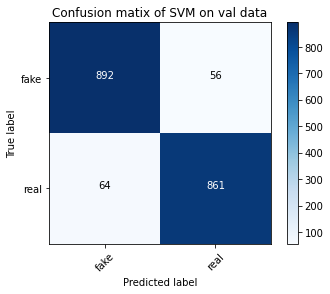

In [11]:
# display results
print_metrics(pred,y_val)
plot_confusion_matrix(confusion_matrix(y_val,pred),target_names=['fake','real'], normalize = False, \
                      title = 'Confusion matix of SVM on val data')